In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib_venn import venn3, venn2
import seaborn as sns

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/strains_rna/results/A10_Manuscript_Figures_AllLiverCells//'
lpsDirectory = '/home/h1bennet/strains/data/RNA/LPS_2h_kupffer_cohort2/'
controlDirectory = '/home/h1bennet/strains/data/RNA/control_kupffer/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


In [3]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

Make folder for figures

In [4]:
if not os.path.isdir('./lps_treatment/'):
    os.mkdir('./lps_treatment/')

Plot our own version of scatter

In [7]:
comps = ['balbc_kupffer_control.vs.balbc_kupffer_lps_2hours.scatter.homer.txt']

ids = [['BALB.*Kupffer', 'balb.*lp']]

labels = [['Control\nLog2(TPM+1)', 'LPS 2hours\nLog2(TPM+1)']]

colors = [['#bdbdbd', '#08519c']]

# set plotting thresholds
pthresh = 0.05
fontsize=8
labelsize=6
lfcthresh = (np.log2(2),2)
dotsize = 1
ax_max = 16
n_yticks = 5
ytickstep = 3
color = '#636363'
filename='lps_treatment_combined_scatter.pdf'

balbc_kupffer_control.vs.balbc_kupffer_lps_2hours.scatter.homer.txt
ge all transcripts (24940, 14)
Diff Gene selected transcripts (9132, 14)
ge selected transcripts (9132, 14)
6272 peaks
1452 genes up in group 1
1408 genes up in group 2


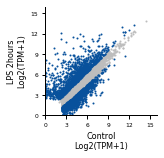

In [8]:
fig, ax = plt.subplots(1,1,
                        figsize=(2,2),
                        sharex=True,
                        sharey=True)
plt.subplots_adjust(wspace=0.2,
                    hspace=0.2)

# set count for labeling axes
count=0

for comp, grep, labs, color in zip(comps, ids, labels, colors):
    print(comp)
    de, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        '../K07_Strains_LPS2htoControl/differential/'+comp,
        '../K07_Strains_LPS2htoControl/expression/HOMER.rawTPM.txt',
        gene_name_index=True)
    
    # extract columns
    g0 = tpm_mat.columns.str.contains(grep[0])
    g1 = tpm_mat.columns.str.contains(grep[1])
    col = g0 | g1
    
    de['logtpm'] = np.log2(tpm_mat.loc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.padj + 10**(-50))
    de['g0_mean'] = np.log2(tpm_mat.loc[:, g0].mean(1)+1)
    de['g1_mean'] = np.log2(tpm_mat.loc[:, g1].mean(1)+1)
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[((de.padj >= pthresh) | (np.abs(de.log2FoldChange) <= lfcthresh[0]))])
    de_sig_fc1 = de.reindex(de.index[(de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])])
    
    # check number of peaks in each group
    print(de_nonsig.shape[0], 'peaks')
    print((de_sig_fc1.log2FoldChange > lfcthresh[0]).sum(), 'genes up in group 1')
    print((de_sig_fc1.log2FoldChange < -lfcthresh[0]).sum(), 'genes up in group 2')
    
    for df, c in zip([de_nonsig, de_sig_fc1],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            rasterized=True
        )
     
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

    ax.set_xlabel(labs[0], fontsize=labelsize+2)
    ax.set_ylabel(labs[1], fontsize=labelsize+2)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    
    count = count + 1
plt.savefig('./lps_treatment/'+filename, bbox_inches='tight')

## Write differential genes to list for metascape

In [16]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [17]:
log2fc = np.log2(2)
pval = 0.05
gene_list_dict ={}

In [18]:
for i in np.sort(glob.glob('./differential/c57*c57*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))

for i in np.sort(glob.glob('./differential/balb*balb*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))
    
for i in np.sort(glob.glob('./differential/aj*aj*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))

./differential/balbc_kupffer_control.vs.balbc_kupffer_lps_2hours.scatter.homer.txt
ge all transcripts (24940, 14)
Diff Gene selected transcripts (9132, 14)
ge selected transcripts (9132, 14)
./differential/balbc_kupffer_lps_2hours.vs.balbc_kupffer_control.scatter.homer.txt
ge all transcripts (24940, 14)
Diff Gene selected transcripts (9132, 14)
ge selected transcripts (9132, 14)


In [19]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_kupffer_genes_fc_%.2f_pval_%.2f_.txt' % (log2fc, pval), 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()

balbc_kupffer_lps_2hours_up
1407 genes
balbc_kupffer_control_up
1381 genes
